<h2>Figure 5, Lipschitz plots only</h2>

In [1]:
import scipy.io
import tensorflow as tf   # tested with tf 1.15.3
import numpy as np
import matplotlib.pyplot as plt
import os
from numpy import genfromtxt
from aux_functions2 import xavier_init
from aux_functions2 import plot #MINE

import csv
import sys

In [2]:
steps = 60000 # number of training steps
iteration = 5 # number of iterations (iid runs based on available files, data shuffled and subsampled at 80%)
d = 16 # dimensions aka proteins
mb_size = 4000 # batch size
alpha_range = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
lam_gp = 0.1  # gradient penalty constant: \lambda_{gp}

w = 0.2 # sick cell contamination
print(steps)
print(iteration)
print(d)
print(mb_size)


60000
5
16
4000


In [3]:
# hyperparameters
if d==6:                       
    layers = [d, 16, 16, 1] 
elif d==15:                       
    layers = [d, 16, 16, 1] 
elif d==2:
    layers = [d, 16, 16, 8, 1]
elif d==10:
    layers = [d, 16, 16, 8, 1]#[d, 32, 32, 16, 1]
elif d == 16:
    layers = [d, 16, 16, 8, 1]
elif d==50:
    layers = [d, 64, 64, 32, 1]
elif d==1:                     
    layers = [d, 8, 8, 4, 1]
else:
    raise Exception("Check dimension and layers...")

lam = 1.0 # lambda=beta+gamma

# initialize
X = tf.placeholder(tf.float32, shape=[None, d])
Y = tf.placeholder(tf.float32, shape=[None, d])

def initialize_NN(layers):
    NN_W = []
    NN_b = []
    num_layers = len(layers)
    for l in range(0,num_layers-1):
        W = tf.Variable(xavier_init(size=[layers[l], layers[l+1]]), name="W")
        b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
        NN_W.append(W)
        NN_b.append(b)
    return NN_W, NN_b

D_W, D_b = initialize_NN(layers)

theta_D = [D_W, D_b] 


In [4]:
def discriminator(x):
    num_layers = len(D_W) + 1
    
    h = x  
    for l in range(0,num_layers-2):
        W = D_W[l]
        b = D_b[l]
        h = tf.tanh(tf.add(tf.matmul(h, W), b))
    
    W = D_W[-1]
    b = D_b[-1]
    out = tf.add(tf.matmul(h, W), b)  # unbounded

    return out

D_real = discriminator(X)
D_fake = discriminator(Y)


In [5]:
config = tf.ConfigProto(device_count={'GPU': 0})
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())

SF = 1000
D_loss_vals =  np.zeros(shape=(len(alpha_range), iteration)) 
D_loss_vals_w_005 =  np.zeros(shape=(len(alpha_range), iteration)) 


In [6]:
# estimate Renyi divergence

# Loop over #samples, then over iid iterations and then over training steps
for j, alpha_i in enumerate(alpha_range): 
    
    print('j=', j)

    #alpha = alpha_range
    #No_alpha = len(alpha_range)

    
    beta = lam*(1-alpha_i)  
    gamma = lam*alpha_i  
    
    
    # variational representation:
    if beta == 0:
        D_loss_real = -tf.reduce_mean(D_real)
    else:
        max_val = tf.reduce_max((-beta) * D_real)
        D_loss_real = (1.0 / beta) * (tf.log(tf.reduce_mean(tf.exp((-beta) * D_real - max_val))) + max_val)

    if gamma == 0:
        D_loss_fake = tf.reduce_mean(D_fake)

    else:
        max_val = tf.reduce_max((gamma) * D_fake)
        D_loss_fake = (1.0 / gamma) * (tf.log(tf.reduce_mean(tf.exp(gamma * D_fake - max_val))) + max_val)

    D_loss = D_loss_real + D_loss_fake

    # Gradient Penalty
    alpha_gp = tf.random_uniform(shape=[mb_size,1], minval=0., maxval=1.)
    interpolates = X + (alpha_gp*(Y - X)) 
    gradients = tf.gradients(discriminator(interpolates), [interpolates])[0]  
    slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), reduction_indices=[1]))
    gradient_penalty = tf.reduce_mean(tf.math.maximum(tf.zeros([slopes.shape[0]], dtype=tf.float32) ,(slopes-5.))**2)  # Lipschitz with K=5 

    total_loss = D_loss + lam_gp*gradient_penalty

    
#    D_solver = tf.train.AdamOptimizer(learning_rate=0.01).minimize(total_loss, var_list=theta_D)
    D_solver = tf.train.AdamOptimizer(learning_rate=0.005).minimize(total_loss, var_list=theta_D)

    for iter in range(iteration):
        print('Iteration: {}'.format(iter))
        sess.run(tf.global_variables_initializer())
        
        # load data
        file_id = iter + 1 
        fname = 'data/all_Healthy_vs_CBF_20perc_markers_1_2_3_4_5_6_7_8_9_10_11_12_13_14_15_16/H3_H4_H5_H6_H7_vs_CBF_perc4_markers_1_2_3_4_5_6_7_8_9_10_11_12_13_14_15_16_'
        data = scipy.io.loadmat(fname + 'iter_'+str(file_id)+'.mat')
        # SWAPPED X<->Y (Y is CBF)
        x = np.array(data['Y'])
        y = np.array(data['X'])

        # initialize for plotting
        i = 0
        Pl_freq = 10
        D_loss_plot = np.zeros(shape=((np.rint(steps / Pl_freq)).astype(int), 1))  # because we writeout every Pl_freq

        for it in range(steps):
            X_mb = x[np.random.randint(x.shape[0], size=mb_size), :]
            Y_mb = y[np.random.randint(y.shape[0], size=mb_size), :]

            _, D_loss_curr, D_tot_loss = sess.run([D_solver, D_loss, total_loss], feed_dict={X: X_mb, Y: Y_mb})

            if it % Pl_freq == 0:
                D_loss_plot[i] = D_loss_curr
                i += 1

            if it % SF == 0:
                print('Iter: {}'.format(it))
                print('Renyi divergence: {}'.format(-lam*D_loss_curr))
                print()


        D_loss_curr = sess.run(D_loss, feed_dict={X: x, Y: y})
        D_loss_vals[j,iter] = -lam * D_loss_curr

        
        
# w=0.05
    for iter in range(iteration):
        print('Iteration: {}'.format(iter))
        sess.run(tf.global_variables_initializer())
        
        # load data
        file_id = iter + 1 
        fname = 'data/all_Healthy_vs_CBF_5perc_markers_1_2_3_4_5_6_7_8_9_10_11_12_13_14_15_16/input_files/H3_H4_H5_H6_H7_vs_CBF_perc2_markers_1_2_3_4_5_6_7_8_9_10_11_12_13_14_15_16_'
        data = scipy.io.loadmat(fname + 'iter_'+str(file_id)+'.mat')
        # SWAPPED X<->Y (Y is CBF)
        x = np.array(data['Y'])
        y = np.array(data['X'])

        # initialize for plotting
        i = 0
        Pl_freq = 10
        D_loss_plot = np.zeros(shape=((np.rint(steps / Pl_freq)).astype(int), 1))  # because we writeout every Pl_freq

        for it in range(steps):
            X_mb = x[np.random.randint(x.shape[0], size=mb_size), :]
            Y_mb = y[np.random.randint(y.shape[0], size=mb_size), :]

            _, D_loss_curr, D_tot_loss = sess.run([D_solver, D_loss, total_loss], feed_dict={X: X_mb, Y: Y_mb})

            if it % Pl_freq == 0:
                D_loss_plot[i] = D_loss_curr
                i += 1

            if it % SF == 0:
                print('Iter: {}'.format(it))
                print('Renyi divergence: {}'.format(-lam*D_loss_curr))
                print()


        D_loss_curr = sess.run(D_loss, feed_dict={X: x, Y: y})
        D_loss_vals_w_005[j,iter] = -lam * D_loss_curr
        
        
    if not os.path.exists('data/out_real_data_Lip_plots/'):
        os.makedirs('data/out_real_data_Lip_plots/')
        
""" 
    # -----------------------------------------------------------------------------
    # Plotting
    # -----------------------------------------------------------------------------

    fig = plt.figure()
    #plt.plot(D_loss_plot)
    x_idx = np.linspace(0, steps, num=(np.rint(steps / Pl_freq)).astype(int))
    plt.plot(x_idx, D_loss_plot)
    plt.xlabel('steps')
    plt.ylabel('D loss')
    plt.savefig('data/out_real_data_BS_plots/cgan_Dloss' + str(j) + 'alpha_' + str(alpha_i) +'.png', bbox_inches='tight')
    plt.close(fig)
"""       

j= 0
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Iteration: 0
Iter: 0
Renyi divergence: -5.805608816444874e-05

Iter: 1000
Renyi divergence: 0.21954083442687988

Iter: 2000
Renyi divergence: 0.23907756805419922

Iter: 3000
Renyi divergence: 0.21899032592773438

Iter: 4000
Renyi divergence: 0.229522705078125

Iter: 5000
Renyi divergence: 0.2420492172241211

Iter: 6000
Renyi divergence: 0.22052645683288574

Iter: 7000
Renyi divergence: 0.22592473030090332

Iter: 8000
Renyi divergence: 0.24135708808898926

Iter: 9000
Renyi divergence: 0.2427356243133545

Iter: 10000
Renyi divergence: 0.23011112213134766

Iter: 11000
Renyi divergence: 0.23126459121704102

Iter: 12000
Renyi divergence: 0.22796845436096191

Iter: 13000
Renyi divergence: 0.2307136058807373

Iter: 14000
Renyi divergence: 0.23551321029663086

Iter: 15000
Renyi divergence: 0.24697232246398926

Iter: 16000
Renyi divergence: 0.231367826461792

Iter: 17000
Renyi divergence: 0.230158

Iter: 35000
Renyi divergence: 0.24161863327026367

Iter: 36000
Renyi divergence: 0.23624038696289062

Iter: 37000
Renyi divergence: 0.24247264862060547

Iter: 38000
Renyi divergence: 0.2315230369567871

Iter: 39000
Renyi divergence: 0.23459863662719727

Iter: 40000
Renyi divergence: 0.24538803100585938

Iter: 41000
Renyi divergence: 0.24409866333007812

Iter: 42000
Renyi divergence: 0.24850082397460938

Iter: 43000
Renyi divergence: 0.2512035369873047

Iter: 44000
Renyi divergence: 0.23289108276367188

Iter: 45000
Renyi divergence: 0.23398208618164062

Iter: 46000
Renyi divergence: 0.22556018829345703

Iter: 47000
Renyi divergence: 0.23886489868164062

Iter: 48000
Renyi divergence: 0.23019886016845703

Iter: 49000
Renyi divergence: 0.23331546783447266

Iter: 50000
Renyi divergence: 0.2538900375366211

Iter: 51000
Renyi divergence: 0.2493906021118164

Iter: 52000
Renyi divergence: 0.2520875930786133

Iter: 53000
Renyi divergence: 0.24376296997070312

Iter: 54000
Renyi divergence: 0.2323

Iter: 17000
Renyi divergence: 0.06714582443237305

Iter: 18000
Renyi divergence: 0.06523275375366211

Iter: 19000
Renyi divergence: 0.06438136100769043

Iter: 20000
Renyi divergence: 0.07241249084472656

Iter: 21000
Renyi divergence: 0.062345027923583984

Iter: 22000
Renyi divergence: 0.06882691383361816

Iter: 23000
Renyi divergence: 0.06859636306762695

Iter: 24000
Renyi divergence: 0.06265974044799805

Iter: 25000
Renyi divergence: 0.06093573570251465

Iter: 26000
Renyi divergence: 0.06826925277709961

Iter: 27000
Renyi divergence: 0.058643341064453125

Iter: 28000
Renyi divergence: 0.06706476211547852

Iter: 29000
Renyi divergence: 0.055356502532958984

Iter: 30000
Renyi divergence: 0.06442403793334961

Iter: 31000
Renyi divergence: 0.06534147262573242

Iter: 32000
Renyi divergence: 0.062245845794677734

Iter: 33000
Renyi divergence: 0.0661764144897461

Iter: 34000
Renyi divergence: 0.07351064682006836

Iter: 35000
Renyi divergence: 0.06967496871948242

Iter: 36000
Renyi divergence

Iter: 58000
Renyi divergence: 0.0664825439453125

Iter: 59000
Renyi divergence: 0.06556892395019531

Iteration: 3
Iter: 0
Renyi divergence: -3.5570701584219933e-06

Iter: 1000
Renyi divergence: 0.045751333236694336

Iter: 2000
Renyi divergence: 0.053858280181884766

Iter: 3000
Renyi divergence: 0.05533313751220703

Iter: 4000
Renyi divergence: 0.0509333610534668

Iter: 5000
Renyi divergence: 0.04941153526306152

Iter: 6000
Renyi divergence: 0.04733610153198242

Iter: 7000
Renyi divergence: 0.054909706115722656

Iter: 8000
Renyi divergence: 0.048856258392333984

Iter: 9000
Renyi divergence: 0.05411529541015625

Iter: 10000
Renyi divergence: 0.06132841110229492

Iter: 11000
Renyi divergence: 0.060858726501464844

Iter: 12000
Renyi divergence: 0.05854320526123047

Iter: 13000
Renyi divergence: 0.05314064025878906

Iter: 14000
Renyi divergence: 0.05855989456176758

Iter: 15000
Renyi divergence: 0.056740760803222656

Iter: 16000
Renyi divergence: 0.05824470520019531

Iter: 17000
Renyi diver

Iter: 39000
Renyi divergence: 0.25915050506591797

Iter: 40000
Renyi divergence: 0.26381874084472656

Iter: 41000
Renyi divergence: 0.2572484016418457

Iter: 42000
Renyi divergence: 0.27956438064575195

Iter: 43000
Renyi divergence: 0.2528495788574219

Iter: 44000
Renyi divergence: 0.2767496109008789

Iter: 45000
Renyi divergence: 0.2628788948059082

Iter: 46000
Renyi divergence: 0.2529435157775879

Iter: 47000
Renyi divergence: 0.2660989761352539

Iter: 48000
Renyi divergence: 0.2758622169494629

Iter: 49000
Renyi divergence: 0.26433658599853516

Iter: 50000
Renyi divergence: 0.2551536560058594

Iter: 51000
Renyi divergence: 0.25527238845825195

Iter: 52000
Renyi divergence: 0.25589847564697266

Iter: 53000
Renyi divergence: 0.28807640075683594

Iter: 54000
Renyi divergence: 0.244598388671875

Iter: 55000
Renyi divergence: 0.2614145278930664

Iter: 56000
Renyi divergence: 0.2740950584411621

Iter: 57000
Renyi divergence: 0.2576441764831543

Iter: 58000
Renyi divergence: 0.275719642639

Iter: 22000
Renyi divergence: 0.26947927474975586

Iter: 23000
Renyi divergence: 0.2543067932128906

Iter: 24000
Renyi divergence: 0.23422479629516602

Iter: 25000
Renyi divergence: 0.26372194290161133

Iter: 26000
Renyi divergence: 0.27263784408569336

Iter: 27000
Renyi divergence: 0.269895076751709

Iter: 28000
Renyi divergence: 0.26061153411865234

Iter: 29000
Renyi divergence: 0.26108741760253906

Iter: 30000
Renyi divergence: 0.24403905868530273

Iter: 31000
Renyi divergence: 0.2686614990234375

Iter: 32000
Renyi divergence: 0.25705957412719727

Iter: 33000
Renyi divergence: 0.25459861755371094

Iter: 34000
Renyi divergence: 0.25655364990234375

Iter: 35000
Renyi divergence: 0.2611055374145508

Iter: 36000
Renyi divergence: 0.26840925216674805

Iter: 37000
Renyi divergence: 0.27211618423461914

Iter: 38000
Renyi divergence: 0.25779008865356445

Iter: 39000
Renyi divergence: 0.24999380111694336

Iter: 40000
Renyi divergence: 0.2539677619934082

Iter: 41000
Renyi divergence: 0.26360

Iter: 4000
Renyi divergence: 0.0604090690612793

Iter: 5000
Renyi divergence: 0.05919170379638672

Iter: 6000
Renyi divergence: 0.06517410278320312

Iter: 7000
Renyi divergence: 0.06380081176757812

Iter: 8000
Renyi divergence: 0.06679153442382812

Iter: 9000
Renyi divergence: 0.0652914047241211

Iter: 10000
Renyi divergence: 0.06581687927246094

Iter: 11000
Renyi divergence: 0.06019306182861328

Iter: 12000
Renyi divergence: 0.05558061599731445

Iter: 13000
Renyi divergence: 0.0696706771850586

Iter: 14000
Renyi divergence: 0.07101011276245117

Iter: 15000
Renyi divergence: 0.0640869140625

Iter: 16000
Renyi divergence: 0.05464792251586914

Iter: 17000
Renyi divergence: 0.06175661087036133

Iter: 18000
Renyi divergence: 0.06968069076538086

Iter: 19000
Renyi divergence: 0.06422948837280273

Iter: 20000
Renyi divergence: 0.0641164779663086

Iter: 21000
Renyi divergence: 0.0695953369140625

Iter: 22000
Renyi divergence: 0.06150054931640625

Iter: 23000
Renyi divergence: 0.06835031509399

Iter: 45000
Renyi divergence: 0.06102752685546875

Iter: 46000
Renyi divergence: 0.06686115264892578

Iter: 47000
Renyi divergence: 0.07976150512695312

Iter: 48000
Renyi divergence: 0.06942319869995117

Iter: 49000
Renyi divergence: 0.07506465911865234

Iter: 50000
Renyi divergence: 0.06707286834716797

Iter: 51000
Renyi divergence: 0.06619548797607422

Iter: 52000
Renyi divergence: 0.0726165771484375

Iter: 53000
Renyi divergence: 0.07216739654541016

Iter: 54000
Renyi divergence: 0.07176971435546875

Iter: 55000
Renyi divergence: 0.06929206848144531

Iter: 56000
Renyi divergence: 0.06822347640991211

Iter: 57000
Renyi divergence: 0.0700373649597168

Iter: 58000
Renyi divergence: 0.064178466796875

Iter: 59000
Renyi divergence: 0.06604528427124023

Iteration: 4
Iter: 0
Renyi divergence: 2.4535111151635647e-05

Iter: 1000
Renyi divergence: 0.04816174507141113

Iter: 2000
Renyi divergence: 0.05068492889404297

Iter: 3000
Renyi divergence: 0.056290626525878906

Iter: 4000
Renyi divergen

Iter: 27000
Renyi divergence: 0.30845165252685547

Iter: 28000
Renyi divergence: 0.29486846923828125

Iter: 29000
Renyi divergence: 0.2912864685058594

Iter: 30000
Renyi divergence: 0.2713279724121094

Iter: 31000
Renyi divergence: 0.30022621154785156

Iter: 32000
Renyi divergence: 0.2952747344970703

Iter: 33000
Renyi divergence: 0.3146076202392578

Iter: 34000
Renyi divergence: 0.2750434875488281

Iter: 35000
Renyi divergence: 0.30950927734375

Iter: 36000
Renyi divergence: 0.302764892578125

Iter: 37000
Renyi divergence: 0.2912864685058594

Iter: 38000
Renyi divergence: 0.2882709503173828

Iter: 39000
Renyi divergence: 0.2959747314453125

Iter: 40000
Renyi divergence: 0.3196907043457031

Iter: 41000
Renyi divergence: 0.29099273681640625

Iter: 42000
Renyi divergence: 0.3000316619873047

Iter: 43000
Renyi divergence: 0.29395103454589844

Iter: 44000
Renyi divergence: 0.29901123046875

Iter: 45000
Renyi divergence: 0.2835559844970703

Iter: 46000
Renyi divergence: 0.3061199188232422



Iter: 10000
Renyi divergence: 0.30856990814208984

Iter: 11000
Renyi divergence: 0.2729473114013672

Iter: 12000
Renyi divergence: 0.2787666320800781

Iter: 13000
Renyi divergence: 0.2960224151611328

Iter: 14000
Renyi divergence: 0.29411983489990234

Iter: 15000
Renyi divergence: 0.2913188934326172

Iter: 16000
Renyi divergence: 0.27678585052490234

Iter: 17000
Renyi divergence: 0.31227779388427734

Iter: 18000
Renyi divergence: 0.3036365509033203

Iter: 19000
Renyi divergence: 0.29080677032470703

Iter: 20000
Renyi divergence: 0.2668743133544922

Iter: 21000
Renyi divergence: 0.2975330352783203

Iter: 22000
Renyi divergence: 0.29911041259765625

Iter: 23000
Renyi divergence: 0.28591156005859375

Iter: 24000
Renyi divergence: 0.2880220413208008

Iter: 25000
Renyi divergence: 0.3145332336425781

Iter: 26000
Renyi divergence: 0.3069124221801758

Iter: 27000
Renyi divergence: 0.30274200439453125

Iter: 28000
Renyi divergence: 0.3300132751464844

Iter: 29000
Renyi divergence: 0.2893877029

Iter: 52000
Renyi divergence: 0.07036399841308594

Iter: 53000
Renyi divergence: 0.0854644775390625

Iter: 54000
Renyi divergence: 0.07444000244140625

Iter: 55000
Renyi divergence: 0.07585906982421875

Iter: 56000
Renyi divergence: 0.07008171081542969

Iter: 57000
Renyi divergence: 0.07756423950195312

Iter: 58000
Renyi divergence: 0.06678009033203125

Iter: 59000
Renyi divergence: 0.07539558410644531

Iteration: 2
Iter: 0
Renyi divergence: 3.038099021068774e-05

Iter: 1000
Renyi divergence: 0.07522892951965332

Iter: 2000
Renyi divergence: 0.06453466415405273

Iter: 3000
Renyi divergence: 0.06969976425170898

Iter: 4000
Renyi divergence: 0.06517171859741211

Iter: 5000
Renyi divergence: 0.061224937438964844

Iter: 6000
Renyi divergence: 0.0692758560180664

Iter: 7000
Renyi divergence: 0.06902170181274414

Iter: 8000
Renyi divergence: 0.07549047470092773

Iter: 9000
Renyi divergence: 0.08043670654296875

Iter: 10000
Renyi divergence: 0.07433414459228516

Iter: 11000
Renyi divergence: 

Iter: 33000
Renyi divergence: 0.07390022277832031

Iter: 34000
Renyi divergence: 0.06748294830322266

Iter: 35000
Renyi divergence: 0.07176876068115234

Iter: 36000
Renyi divergence: 0.07794761657714844

Iter: 37000
Renyi divergence: 0.0744171142578125

Iter: 38000
Renyi divergence: 0.07769203186035156

Iter: 39000
Renyi divergence: 0.07799530029296875

Iter: 40000
Renyi divergence: 0.06987476348876953

Iter: 41000
Renyi divergence: 0.07288742065429688

Iter: 42000
Renyi divergence: 0.08612918853759766

Iter: 43000
Renyi divergence: 0.07555007934570312

Iter: 44000
Renyi divergence: 0.07978248596191406

Iter: 45000
Renyi divergence: 0.08118343353271484

Iter: 46000
Renyi divergence: 0.07960891723632812

Iter: 47000
Renyi divergence: 0.07803058624267578

Iter: 48000
Renyi divergence: 0.06724262237548828

Iter: 49000
Renyi divergence: 0.07662773132324219

Iter: 50000
Renyi divergence: 0.07352447509765625

Iter: 51000
Renyi divergence: 0.07217788696289062

Iter: 52000
Renyi divergence: 0.

Iter: 16000
Renyi divergence: 0.32815122604370117

Iter: 17000
Renyi divergence: 0.31280946731567383

Iter: 18000
Renyi divergence: 0.35097265243530273

Iter: 19000
Renyi divergence: 0.35636305809020996

Iter: 20000
Renyi divergence: 0.32853150367736816

Iter: 21000
Renyi divergence: 0.3330347537994385

Iter: 22000
Renyi divergence: 0.3411710262298584

Iter: 23000
Renyi divergence: 0.34309911727905273

Iter: 24000
Renyi divergence: 0.3409397602081299

Iter: 25000
Renyi divergence: 0.3290832042694092

Iter: 26000
Renyi divergence: 0.358396053314209

Iter: 27000
Renyi divergence: 0.3524477481842041

Iter: 28000
Renyi divergence: 0.36652445793151855

Iter: 29000
Renyi divergence: 0.3382474184036255

Iter: 30000
Renyi divergence: 0.34545838832855225

Iter: 31000
Renyi divergence: 0.3205481767654419

Iter: 32000
Renyi divergence: 0.3399776220321655

Iter: 33000
Renyi divergence: 0.3355328440666199

Iter: 34000
Renyi divergence: 0.35013866424560547

Iter: 35000
Renyi divergence: 0.3318509459

Iter: 59000
Renyi divergence: 0.330930233001709

Iteration: 0
Iter: 0
Renyi divergence: -5.272391717880964e-06

Iter: 1000
Renyi divergence: 0.06802797317504883

Iter: 2000
Renyi divergence: 0.06117439270019531

Iter: 3000
Renyi divergence: 0.0696711540222168

Iter: 4000
Renyi divergence: 0.06952047348022461

Iter: 5000
Renyi divergence: 0.06908845901489258

Iter: 6000
Renyi divergence: 0.07361412048339844

Iter: 7000
Renyi divergence: 0.0745229721069336

Iter: 8000
Renyi divergence: 0.07466268539428711

Iter: 9000
Renyi divergence: 0.08542394638061523

Iter: 10000
Renyi divergence: 0.07367515563964844

Iter: 11000
Renyi divergence: 0.08779001235961914

Iter: 12000
Renyi divergence: 0.08436298370361328

Iter: 13000
Renyi divergence: 0.0707550048828125

Iter: 14000
Renyi divergence: 0.07674074172973633

Iter: 15000
Renyi divergence: 0.07080745697021484

Iter: 16000
Renyi divergence: 0.09552121162414551

Iter: 17000
Renyi divergence: 0.07945871353149414

Iter: 18000
Renyi divergence: 0.0

Iter: 41000
Renyi divergence: 0.07851982116699219

Iter: 42000
Renyi divergence: 0.08427810668945312

Iter: 43000
Renyi divergence: 0.0834360122680664

Iter: 44000
Renyi divergence: 0.09829330444335938

Iter: 45000
Renyi divergence: 0.09548473358154297

Iter: 46000
Renyi divergence: 0.09019851684570312

Iter: 47000
Renyi divergence: 0.08109283447265625

Iter: 48000
Renyi divergence: 0.07819271087646484

Iter: 49000
Renyi divergence: 0.0849771499633789

Iter: 50000
Renyi divergence: 0.08466815948486328

Iter: 51000
Renyi divergence: 0.0946950912475586

Iter: 52000
Renyi divergence: 0.08316898345947266

Iter: 53000
Renyi divergence: 0.08760261535644531

Iter: 54000
Renyi divergence: 0.09541606903076172

Iter: 55000
Renyi divergence: 0.08905220031738281

Iter: 56000
Renyi divergence: 0.10625553131103516

Iter: 57000
Renyi divergence: 0.08190727233886719

Iter: 58000
Renyi divergence: 0.09322357177734375

Iter: 59000
Renyi divergence: 0.09252262115478516

Iteration: 3
Iter: 0
Renyi diverge

Iter: 22000
Renyi divergence: 0.42004823684692383

Iter: 23000
Renyi divergence: 0.39934539794921875

Iter: 24000
Renyi divergence: 0.3844590187072754

Iter: 25000
Renyi divergence: 0.40903568267822266

Iter: 26000
Renyi divergence: 0.3622584342956543

Iter: 27000
Renyi divergence: 0.38075685501098633

Iter: 28000
Renyi divergence: 0.4142289161682129

Iter: 29000
Renyi divergence: 0.3952789306640625

Iter: 30000
Renyi divergence: 0.40756797790527344

Iter: 31000
Renyi divergence: 0.37730932235717773

Iter: 32000
Renyi divergence: 0.3910713195800781

Iter: 33000
Renyi divergence: 0.3827219009399414

Iter: 34000
Renyi divergence: 0.40894126892089844

Iter: 35000
Renyi divergence: 0.40462684631347656

Iter: 36000
Renyi divergence: 0.3994779586791992

Iter: 37000
Renyi divergence: 0.39954280853271484

Iter: 38000
Renyi divergence: 0.4035181999206543

Iter: 39000
Renyi divergence: 0.4026637077331543

Iter: 40000
Renyi divergence: 0.41034603118896484

Iter: 41000
Renyi divergence: 0.41127252

Iter: 5000
Renyi divergence: 0.4104623794555664

Iter: 6000
Renyi divergence: 0.40366268157958984

Iter: 7000
Renyi divergence: 0.4227595329284668

Iter: 8000
Renyi divergence: 0.39750242233276367

Iter: 9000
Renyi divergence: 0.39150428771972656

Iter: 10000
Renyi divergence: 0.3860797882080078

Iter: 11000
Renyi divergence: 0.38809871673583984

Iter: 12000
Renyi divergence: 0.40848255157470703

Iter: 13000
Renyi divergence: 0.4092864990234375

Iter: 14000
Renyi divergence: 0.36548328399658203

Iter: 15000
Renyi divergence: 0.3935995101928711

Iter: 16000
Renyi divergence: 0.4284172058105469

Iter: 17000
Renyi divergence: 0.41031551361083984

Iter: 18000
Renyi divergence: 0.3981332778930664

Iter: 19000
Renyi divergence: 0.37567996978759766

Iter: 20000
Renyi divergence: 0.4036111831665039

Iter: 21000
Renyi divergence: 0.39849376678466797

Iter: 22000
Renyi divergence: 0.38666534423828125

Iter: 23000
Renyi divergence: 0.40291309356689453

Iter: 24000
Renyi divergence: 0.367341041564

Iter: 48000
Renyi divergence: 0.10350179672241211

Iter: 49000
Renyi divergence: 0.09414958953857422

Iter: 50000
Renyi divergence: 0.10862207412719727

Iter: 51000
Renyi divergence: 0.10353422164916992

Iter: 52000
Renyi divergence: 0.09353876113891602

Iter: 53000
Renyi divergence: 0.1149454116821289

Iter: 54000
Renyi divergence: 0.10801315307617188

Iter: 55000
Renyi divergence: 0.09669113159179688

Iter: 56000
Renyi divergence: 0.11146211624145508

Iter: 57000
Renyi divergence: 0.09958267211914062

Iter: 58000
Renyi divergence: 0.10326099395751953

Iter: 59000
Renyi divergence: 0.10825681686401367

Iteration: 1
Iter: 0
Renyi divergence: 7.109716534614563e-06

Iter: 1000
Renyi divergence: 0.07877349853515625

Iter: 2000
Renyi divergence: 0.08492708206176758

Iter: 3000
Renyi divergence: 0.07739639282226562

Iter: 4000
Renyi divergence: 0.09067296981811523

Iter: 5000
Renyi divergence: 0.08910799026489258

Iter: 6000
Renyi divergence: 0.08988046646118164

Iter: 7000
Renyi divergence

Iter: 30000
Renyi divergence: 0.09244680404663086

Iter: 31000
Renyi divergence: 0.10493278503417969

Iter: 32000
Renyi divergence: 0.1045689582824707

Iter: 33000
Renyi divergence: 0.10253715515136719

Iter: 34000
Renyi divergence: 0.0926656723022461

Iter: 35000
Renyi divergence: 0.10582971572875977

Iter: 36000
Renyi divergence: 0.10323953628540039

Iter: 37000
Renyi divergence: 0.11132431030273438

Iter: 38000
Renyi divergence: 0.09891128540039062

Iter: 39000
Renyi divergence: 0.10367155075073242

Iter: 40000
Renyi divergence: 0.10075855255126953

Iter: 41000
Renyi divergence: 0.09515857696533203

Iter: 42000
Renyi divergence: 0.09721040725708008

Iter: 43000
Renyi divergence: 0.09430336952209473

Iter: 44000
Renyi divergence: 0.09615373611450195

Iter: 45000
Renyi divergence: 0.08916330337524414

Iter: 46000
Renyi divergence: 0.09643912315368652

Iter: 47000
Renyi divergence: 0.09736371040344238

Iter: 48000
Renyi divergence: 0.09758615493774414

Iter: 49000
Renyi divergence: 0.1

Iter: 12000
Renyi divergence: 0.46534252166748047

Iter: 13000
Renyi divergence: 0.4600200653076172

Iter: 14000
Renyi divergence: 0.4616985321044922

Iter: 15000
Renyi divergence: 0.4828968048095703

Iter: 16000
Renyi divergence: 0.4921913146972656

Iter: 17000
Renyi divergence: 0.44707679748535156

Iter: 18000
Renyi divergence: 0.4616279602050781

Iter: 19000
Renyi divergence: 0.4701061248779297

Iter: 20000
Renyi divergence: 0.49107933044433594

Iter: 21000
Renyi divergence: 0.4694995880126953

Iter: 22000
Renyi divergence: 0.4806842803955078

Iter: 23000
Renyi divergence: 0.47438812255859375

Iter: 24000
Renyi divergence: 0.46956443786621094

Iter: 25000
Renyi divergence: 0.4815692901611328

Iter: 26000
Renyi divergence: 0.470611572265625

Iter: 27000
Renyi divergence: 0.5114059448242188

Iter: 28000
Renyi divergence: 0.4927825927734375

Iter: 29000
Renyi divergence: 0.5049419403076172

Iter: 30000
Renyi divergence: 0.46708106994628906

Iter: 31000
Renyi divergence: 0.4951305389404

Iter: 56000
Renyi divergence: 0.4685249328613281

Iter: 57000
Renyi divergence: 0.47786712646484375

Iter: 58000
Renyi divergence: 0.4759063720703125

Iter: 59000
Renyi divergence: 0.481231689453125

Iteration: 4
Iter: 0
Renyi divergence: 4.636854282580316e-05

Iter: 1000
Renyi divergence: 0.4496288299560547

Iter: 2000
Renyi divergence: 0.44728660583496094

Iter: 3000
Renyi divergence: 0.45601463317871094

Iter: 4000
Renyi divergence: 0.43892860412597656

Iter: 5000
Renyi divergence: 0.47069263458251953

Iter: 6000
Renyi divergence: 0.4647235870361328

Iter: 7000
Renyi divergence: 0.46446800231933594

Iter: 8000
Renyi divergence: 0.4544334411621094

Iter: 9000
Renyi divergence: 0.47942543029785156

Iter: 10000
Renyi divergence: 0.4648323059082031

Iter: 11000
Renyi divergence: 0.4712667465209961

Iter: 12000
Renyi divergence: 0.4254016876220703

Iter: 13000
Renyi divergence: 0.49582862854003906

Iter: 14000
Renyi divergence: 0.46164703369140625

Iter: 15000
Renyi divergence: 0.4643955

Iter: 38000
Renyi divergence: 0.12162399291992188

Iter: 39000
Renyi divergence: 0.12725830078125

Iter: 40000
Renyi divergence: 0.12242889404296875

Iter: 41000
Renyi divergence: 0.10305404663085938

Iter: 42000
Renyi divergence: 0.12187004089355469

Iter: 43000
Renyi divergence: 0.12942886352539062

Iter: 44000
Renyi divergence: 0.12357711791992188

Iter: 45000
Renyi divergence: 0.11847496032714844

Iter: 46000
Renyi divergence: 0.10788345336914062

Iter: 47000
Renyi divergence: 0.12047386169433594

Iter: 48000
Renyi divergence: 0.12814903259277344

Iter: 49000
Renyi divergence: 0.11695480346679688

Iter: 50000
Renyi divergence: 0.12856674194335938

Iter: 51000
Renyi divergence: 0.12487411499023438

Iter: 52000
Renyi divergence: 0.09937477111816406

Iter: 53000
Renyi divergence: 0.1142425537109375

Iter: 54000
Renyi divergence: 0.11862945556640625

Iter: 55000
Renyi divergence: 0.11879158020019531

Iter: 56000
Renyi divergence: 0.11747550964355469

Iter: 57000
Renyi divergence: 0.108

Iter: 20000
Renyi divergence: 0.11431121826171875

Iter: 21000
Renyi divergence: 0.1292285919189453

Iter: 22000
Renyi divergence: 0.127777099609375

Iter: 23000
Renyi divergence: 0.11426162719726562

Iter: 24000
Renyi divergence: 0.12138557434082031

Iter: 25000
Renyi divergence: 0.1270313262939453

Iter: 26000
Renyi divergence: 0.11397361755371094

Iter: 27000
Renyi divergence: 0.12910842895507812

Iter: 28000
Renyi divergence: 0.13129234313964844

Iter: 29000
Renyi divergence: 0.12269973754882812

Iter: 30000
Renyi divergence: 0.11714553833007812

Iter: 31000
Renyi divergence: 0.12884521484375

Iter: 32000
Renyi divergence: 0.11029434204101562

Iter: 33000
Renyi divergence: 0.0945281982421875

Iter: 34000
Renyi divergence: 0.11950302124023438

Iter: 35000
Renyi divergence: 0.12371253967285156

Iter: 36000
Renyi divergence: 0.1285381317138672

Iter: 37000
Renyi divergence: 0.11739349365234375

Iter: 38000
Renyi divergence: 0.120513916015625

Iter: 39000
Renyi divergence: 0.1367111206

Iter: 4000
Renyi divergence: 0.5440855026245117

Iter: 5000
Renyi divergence: 0.5790891647338867

Iter: 6000
Renyi divergence: 0.5934848785400391

Iter: 7000
Renyi divergence: 0.607330322265625

Iter: 8000
Renyi divergence: 0.5997333526611328

Iter: 9000
Renyi divergence: 0.6395998001098633

Iter: 10000
Renyi divergence: 0.5965662002563477

Iter: 11000
Renyi divergence: 0.6078872680664062

Iter: 12000
Renyi divergence: 0.5831775665283203

Iter: 13000
Renyi divergence: 0.6063518524169922

Iter: 14000
Renyi divergence: 0.647892951965332

Iter: 15000
Renyi divergence: 0.6548042297363281

Iter: 16000
Renyi divergence: 0.6181230545043945

Iter: 17000
Renyi divergence: 0.5751533508300781

Iter: 18000
Renyi divergence: 0.6030483245849609

Iter: 19000
Renyi divergence: 0.605280876159668

Iter: 20000
Renyi divergence: 0.6678895950317383

Iter: 21000
Renyi divergence: 0.6494045257568359

Iter: 22000
Renyi divergence: 0.619938850402832

Iter: 23000
Renyi divergence: 0.6592292785644531

Iter: 2400

Iter: 49000
Renyi divergence: 0.6391019821166992

Iter: 50000
Renyi divergence: 0.6156759262084961

Iter: 51000
Renyi divergence: 0.655980110168457

Iter: 52000
Renyi divergence: 0.6646957397460938

Iter: 53000
Renyi divergence: 0.6272134780883789

Iter: 54000
Renyi divergence: 0.6571903228759766

Iter: 55000
Renyi divergence: 0.6357364654541016

Iter: 56000
Renyi divergence: 0.6083278656005859

Iter: 57000
Renyi divergence: 0.6312227249145508

Iter: 58000
Renyi divergence: 0.6320152282714844

Iter: 59000
Renyi divergence: 0.6457395553588867

Iteration: 0
Iter: 0
Renyi divergence: -1.6482386854477227e-05

Iter: 1000
Renyi divergence: 0.12207698822021484

Iter: 2000
Renyi divergence: 0.12019872665405273

Iter: 3000
Renyi divergence: 0.1130528450012207

Iter: 4000
Renyi divergence: 0.11244964599609375

Iter: 5000
Renyi divergence: 0.14292335510253906

Iter: 6000
Renyi divergence: 0.1399993896484375

Iter: 7000
Renyi divergence: 0.11344242095947266

Iter: 8000
Renyi divergence: 0.14100456

Iter: 31000
Renyi divergence: 0.15743637084960938

Iter: 32000
Renyi divergence: 0.15696334838867188

Iter: 33000
Renyi divergence: 0.13754749298095703

Iter: 34000
Renyi divergence: 0.16873407363891602

Iter: 35000
Renyi divergence: 0.1517186164855957

Iter: 36000
Renyi divergence: 0.1474289894104004

Iter: 37000
Renyi divergence: 0.16563081741333008

Iter: 38000
Renyi divergence: 0.14810562133789062

Iter: 39000
Renyi divergence: 0.15843725204467773

Iter: 40000
Renyi divergence: 0.13878583908081055

Iter: 41000
Renyi divergence: 0.14768123626708984

Iter: 42000
Renyi divergence: 0.1414775848388672

Iter: 43000
Renyi divergence: 0.13781118392944336

Iter: 44000
Renyi divergence: 0.12575435638427734

Iter: 45000
Renyi divergence: 0.14725875854492188

Iter: 46000
Renyi divergence: 0.13463497161865234

Iter: 47000
Renyi divergence: 0.1426994800567627

Iter: 48000
Renyi divergence: 0.15717816352844238

Iter: 49000
Renyi divergence: 0.13906478881835938

Iter: 50000
Renyi divergence: 0.149

Iter: 13000
Renyi divergence: 0.8446054458618164

Iter: 14000
Renyi divergence: 0.7955312728881836

Iter: 15000
Renyi divergence: 0.8954324722290039

Iter: 16000
Renyi divergence: 0.8549528121948242

Iter: 17000
Renyi divergence: 0.8912887573242188

Iter: 18000
Renyi divergence: 0.8013687133789062

Iter: 19000
Renyi divergence: 0.8687725067138672

Iter: 20000
Renyi divergence: 0.8640327453613281

Iter: 21000
Renyi divergence: 0.8490371704101562

Iter: 22000
Renyi divergence: 0.8123502731323242

Iter: 23000
Renyi divergence: 0.8658409118652344

Iter: 24000
Renyi divergence: 0.8215246200561523

Iter: 25000
Renyi divergence: 0.8655080795288086

Iter: 26000
Renyi divergence: 0.8438911437988281

Iter: 27000
Renyi divergence: 0.8940544128417969

Iter: 28000
Renyi divergence: 0.7907695770263672

Iter: 29000
Renyi divergence: 0.8314437866210938

Iter: 30000
Renyi divergence: 0.8255939483642578

Iter: 31000
Renyi divergence: 0.8593940734863281

Iter: 32000
Renyi divergence: 0.8503189086914062



Iter: 57000
Renyi divergence: 0.7866935729980469

Iter: 58000
Renyi divergence: 0.838709831237793

Iter: 59000
Renyi divergence: 0.8691902160644531

Iteration: 3
Iter: 0
Renyi divergence: -0.00015964626800268888

Iter: 1000
Renyi divergence: 0.7560911178588867

Iter: 2000
Renyi divergence: 0.725367546081543

Iter: 3000
Renyi divergence: 0.7910842895507812

Iter: 4000
Renyi divergence: 0.7252941131591797

Iter: 5000
Renyi divergence: 0.7585153579711914

Iter: 6000
Renyi divergence: 0.83636474609375

Iter: 7000
Renyi divergence: 0.7201862335205078

Iter: 8000
Renyi divergence: 0.7533111572265625

Iter: 9000
Renyi divergence: 0.8445072174072266

Iter: 10000
Renyi divergence: 0.8164510726928711

Iter: 11000
Renyi divergence: 0.8278398513793945

Iter: 12000
Renyi divergence: 0.8212757110595703

Iter: 13000
Renyi divergence: 0.8381567001342773

Iter: 14000
Renyi divergence: 0.8750209808349609

Iter: 15000
Renyi divergence: 0.8596992492675781

Iter: 16000
Renyi divergence: 0.9162521362304688


Iter: 41000
Renyi divergence: 0.21413421630859375

Iter: 42000
Renyi divergence: 0.19597721099853516

Iter: 43000
Renyi divergence: 0.18147850036621094

Iter: 44000
Renyi divergence: 0.19768619537353516

Iter: 45000
Renyi divergence: 0.2001323699951172

Iter: 46000
Renyi divergence: 0.20278453826904297

Iter: 47000
Renyi divergence: 0.16666412353515625

Iter: 48000
Renyi divergence: 0.20073699951171875

Iter: 49000
Renyi divergence: 0.19601821899414062

Iter: 50000
Renyi divergence: 0.15392303466796875

Iter: 51000
Renyi divergence: 0.19855785369873047

Iter: 52000
Renyi divergence: 0.1821584701538086

Iter: 53000
Renyi divergence: 0.19518470764160156

Iter: 54000
Renyi divergence: 0.2082967758178711

Iter: 55000
Renyi divergence: 0.21429061889648438

Iter: 56000
Renyi divergence: 0.1876220703125

Iter: 57000
Renyi divergence: 0.19141387939453125

Iter: 58000
Renyi divergence: 0.2012491226196289

Iter: 59000
Renyi divergence: 0.1756610870361328

Iteration: 1
Iter: 0
Renyi divergence: 7

Iter: 23000
Renyi divergence: 0.1631641387939453

Iter: 24000
Renyi divergence: 0.16939544677734375

Iter: 25000
Renyi divergence: 0.1888141632080078

Iter: 26000
Renyi divergence: 0.1759033203125

Iter: 27000
Renyi divergence: 0.21651840209960938

Iter: 28000
Renyi divergence: 0.1793498992919922

Iter: 29000
Renyi divergence: 0.1987018585205078

Iter: 30000
Renyi divergence: 0.18532562255859375

Iter: 31000
Renyi divergence: 0.17506027221679688

Iter: 32000
Renyi divergence: 0.1567974090576172

Iter: 33000
Renyi divergence: 0.22123146057128906

Iter: 34000
Renyi divergence: 0.1665973663330078

Iter: 35000
Renyi divergence: 0.2032451629638672

Iter: 36000
Renyi divergence: 0.19541358947753906

Iter: 37000
Renyi divergence: 0.20301437377929688

Iter: 38000
Renyi divergence: 0.1879901885986328

Iter: 39000
Renyi divergence: 0.1899738311767578

Iter: 40000
Renyi divergence: 0.17774200439453125

Iter: 41000
Renyi divergence: 0.1888256072998047

Iter: 42000
Renyi divergence: 0.1881504058837

Iter: 6000
Renyi divergence: 0.8401460647583008

Iter: 7000
Renyi divergence: 1.3328132629394531

Iter: 8000
Renyi divergence: 1.2339286804199219

Iter: 9000
Renyi divergence: 1.0374374389648438

Iter: 10000
Renyi divergence: 1.3904075622558594

Iter: 11000
Renyi divergence: 1.2233009338378906

Iter: 12000
Renyi divergence: 1.3243122100830078

Iter: 13000
Renyi divergence: 1.4423446655273438

Iter: 14000
Renyi divergence: 1.3791961669921875

Iter: 15000
Renyi divergence: 1.3896980285644531

Iter: 16000
Renyi divergence: 1.377157211303711

Iter: 17000
Renyi divergence: 1.3969402313232422

Iter: 18000
Renyi divergence: 1.3401679992675781

Iter: 19000
Renyi divergence: 1.4674816131591797

Iter: 20000
Renyi divergence: 1.4807205200195312

Iter: 21000
Renyi divergence: 1.4435710906982422

Iter: 22000
Renyi divergence: 1.4370918273925781

Iter: 23000
Renyi divergence: 1.4610404968261719

Iter: 24000
Renyi divergence: 1.4449806213378906

Iter: 25000
Renyi divergence: 1.5537757873535156

Iter:

Iter: 51000
Renyi divergence: 1.3754615783691406

Iter: 52000
Renyi divergence: 1.0483665466308594

Iter: 53000
Renyi divergence: 1.5778427124023438

Iter: 54000
Renyi divergence: 1.5760917663574219

Iter: 55000
Renyi divergence: 1.4325790405273438

Iter: 56000
Renyi divergence: 1.149658203125

Iter: 57000
Renyi divergence: 1.5472564697265625

Iter: 58000
Renyi divergence: 1.3588905334472656

Iter: 59000
Renyi divergence: 1.4801826477050781

Iteration: 4
Iter: 0
Renyi divergence: 7.29762832634151e-05

Iter: 1000
Renyi divergence: 0.9515800476074219

Iter: 2000
Renyi divergence: 1.1124258041381836

Iter: 3000
Renyi divergence: 1.3420991897583008

Iter: 4000
Renyi divergence: 1.0973892211914062

Iter: 5000
Renyi divergence: 1.1560497283935547

Iter: 6000
Renyi divergence: 1.2796306610107422

Iter: 7000
Renyi divergence: 1.3244714736938477

Iter: 8000
Renyi divergence: 1.3062515258789062

Iter: 9000
Renyi divergence: 1.4092483520507812

Iter: 10000
Renyi divergence: 1.4091320037841797

It

Iter: 35000
Renyi divergence: 0.31172943115234375

Iter: 36000
Renyi divergence: 0.3012847900390625

Iter: 37000
Renyi divergence: 0.3407173156738281

Iter: 38000
Renyi divergence: 0.28635406494140625

Iter: 39000
Renyi divergence: 0.2911643981933594

Iter: 40000
Renyi divergence: 0.2853584289550781

Iter: 41000
Renyi divergence: 0.183746337890625

Iter: 42000
Renyi divergence: 0.16272735595703125

Iter: 43000
Renyi divergence: 0.3181877136230469

Iter: 44000
Renyi divergence: 0.3011054992675781

Iter: 45000
Renyi divergence: 0.3048439025878906

Iter: 46000
Renyi divergence: 0.3137245178222656

Iter: 47000
Renyi divergence: 0.3155517578125

Iter: 48000
Renyi divergence: 0.3342247009277344

Iter: 49000
Renyi divergence: 0.30570220947265625

Iter: 50000
Renyi divergence: 0.2692909240722656

Iter: 51000
Renyi divergence: 0.19086837768554688

Iter: 52000
Renyi divergence: 0.31833648681640625

Iter: 53000
Renyi divergence: 0.3317909240722656

Iter: 54000
Renyi divergence: 0.3378868103027344

Iter: 18000
Renyi divergence: 0.34052276611328125

Iter: 19000
Renyi divergence: 0.2121868133544922

Iter: 20000
Renyi divergence: 0.3253955841064453

Iter: 21000
Renyi divergence: 0.3282890319824219

Iter: 22000
Renyi divergence: 0.2755470275878906

Iter: 23000
Renyi divergence: 0.237030029296875

Iter: 24000
Renyi divergence: 0.2943572998046875

Iter: 25000
Renyi divergence: 0.31702232360839844

Iter: 26000
Renyi divergence: 0.2556304931640625

Iter: 27000
Renyi divergence: 0.22049713134765625

Iter: 28000
Renyi divergence: 0.2959575653076172

Iter: 29000
Renyi divergence: 0.3326416015625

Iter: 30000
Renyi divergence: 0.2852287292480469

Iter: 31000
Renyi divergence: 0.2779083251953125

Iter: 32000
Renyi divergence: 0.36640167236328125

Iter: 33000
Renyi divergence: 0.271728515625

Iter: 34000
Renyi divergence: 0.3036689758300781

Iter: 35000
Renyi divergence: 0.2659416198730469

Iter: 36000
Renyi divergence: 0.31363677978515625

Iter: 37000
Renyi divergence: 0.3244438171386719

Ite

" \n    # -----------------------------------------------------------------------------\n    # Plotting\n    # -----------------------------------------------------------------------------\n\n    fig = plt.figure()\n    #plt.plot(D_loss_plot)\n    x_idx = np.linspace(0, steps, num=(np.rint(steps / Pl_freq)).astype(int))\n    plt.plot(x_idx, D_loss_plot)\n    plt.xlabel('steps')\n    plt.ylabel('D loss')\n    plt.savefig('data/out_real_data_BS_plots/cgan_Dloss' + str(j) + 'alpha_' + str(alpha_i) +'.png', bbox_inches='tight')\n    plt.close(fig)\n"

In [7]:
print(D_loss_vals)

[[0.23743379 0.2403717  0.24211311 0.24064636 0.24283409]
 [0.26450825 0.26567936 0.26858234 0.26700687 0.2691226 ]
 [0.2976799  0.29951286 0.29978561 0.29725647 0.29694939]
 [0.34237409 0.34482098 0.34474277 0.3408708  0.34335184]
 [0.40295637 0.40336835 0.40529346 0.40325832 0.40259457]
 [0.48664093 0.48848724 0.49104691 0.48852158 0.48968887]
 [0.62854195 0.63043213 0.62641907 0.6294961  0.62683582]
 [0.86457062 0.89068031 0.88377094 0.87574577 0.8633213 ]
 [1.45583725 1.51342392 1.47351837 1.50904846 1.45079803]]


In [8]:
print(D_loss_vals_w_005)

[[0.06625462 0.06212044 0.06119633 0.06359959 0.07125092]
 [0.06716251 0.07197809 0.06992674 0.06864452 0.06750965]
 [0.07631302 0.07738304 0.07726669 0.07307148 0.07510376]
 [0.08756447 0.08625889 0.08864498 0.08362889 0.08712721]
 [0.10190344 0.09901595 0.09809494 0.0992713  0.09914082]
 [0.11865044 0.1166954  0.11505127 0.11774063 0.12060928]
 [0.14651966 0.14478934 0.15021825 0.14577198 0.14301252]
 [0.20181561 0.19962406 0.20338058 0.19786358 0.20129013]
 [0.34060287 0.32883453 0.30621719 0.20103073 0.33737946]]


In [9]:
   
fname = 'data/out_real_data_Lip_plots/'
with open(fname+'lambda_'+str(lam)+'_bs_'+str(mb_size)+'_nerd_'+str(w)+'.csv', "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    for val in D_loss_vals:
        writer.writerow(val)

w=0.05
with open(fname+'lambda_'+str(lam)+'_bs_'+str(mb_size)+'_nerd_'+str(w)+'.csv', "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    for val in D_loss_vals_w_005:
        writer.writerow(val)
        

In [11]:
# plot errorbars
RD_M50_mean = np.mean(D_loss_vals, axis=1)  # means per alpha value
RD_M50_mean_w_005 = np.mean(D_loss_vals_w_005, axis=1)

In [12]:
RD_M50_std = np.std(D_loss_vals, axis=1)  # means per alpha value
RD_M50_std_w_005 = np.std(D_loss_vals_w_005, axis=1)  # means per alpha value


In [13]:
# load ITE toolbox estimates (runs with matlab, saved in .mat files)
fname = 'data/ITE_computations_H3_H4_H5_H6_H7_vs_CBF_perc4_markers_1_2_3_4_5_6_7_8_9_10_11_12_13_14_15_16_alpha_0.1_upto_0.9_H_first_1minalpha'
data_ITE = scipy.io.loadmat(fname +'.mat')

RD_ITE_mean = np.array(data_ITE['RD_ITE_mean'])
RD_ITE_std = np.array(data_ITE['RD_ITE_std'])

fname = 'data/ITE_computations_H3_H4_H5_H6_H7_vs_CBF_perc2_markers_1_2_3_4_5_6_7_8_9_10_11_12_13_14_15_16_alpha_0.1_upto_0.9_H_first_1minalpha'
data_ITE_w_005 = scipy.io.loadmat(fname +'.mat')

RD_ITE_mean_w_005 = np.array(data_ITE_w_005['RD_ITE_mean'])
RD_ITE_std_w_005 = np.array(data_ITE_w_005['RD_ITE_std'])

(-0.5, 0.3)

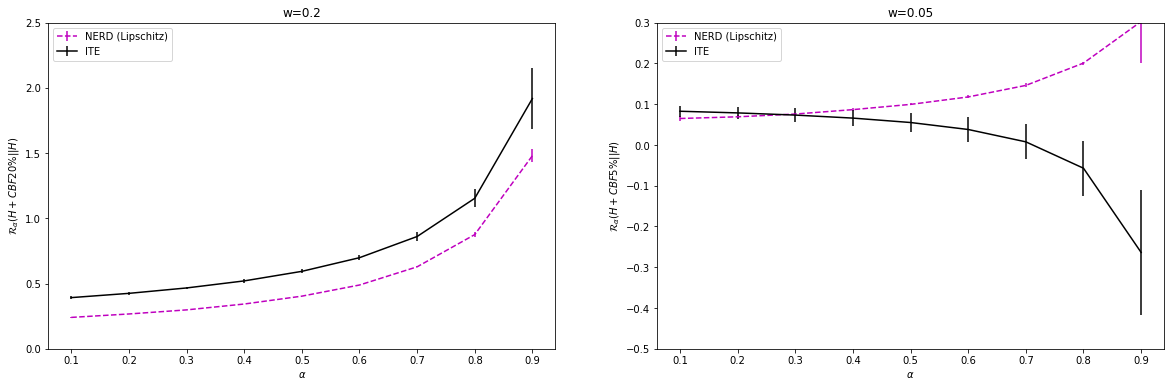

In [20]:
plt.figure(figsize=(20,6))

ax1 = plt.subplot(1,2,1)
ax1.set_title('w=0.2')
ax1.errorbar(alpha_range, RD_M50_mean, 1.96*RD_M50_std, color= 'm', linestyle='dashed', label='NERD (Lipschitz)')
ax1.errorbar(alpha_range, RD_ITE_mean.ravel(), 1.96*RD_ITE_std.ravel(), color= 'k', label='ITE')
plt.legend(loc=2)

plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\mathcal{R}_{\alpha}(H+CBF 20\% ||H)$')
plt.ylim(0.0, 2.5)


ax2 = plt.subplot(1,2,2)
ax2.set_title('w=0.05')
ax2.errorbar(alpha_range, RD_M50_mean_w_005, 1.96*RD_M50_std_w_005, color= 'm', linestyle='dashed', label='NERD (Lipschitz)')
ax2.errorbar(alpha_range, RD_ITE_mean_w_005.ravel(), 1.96*RD_ITE_std_w_005.ravel(), color= 'k', label='ITE')
plt.legend(loc=2)

plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\mathcal{R}_{\alpha}(H+CBF 5\% ||H)$')
plt.ylim(-0.5, 0.3)



In [ ]:
print('program terminated succesfully')